## Intro to Obspy

In this lab of the ErSE 210 - Seismology course, we will look at *Obspy*.

Obspy is a very popular and powerful Python library for processing of seismological data. It comes with a lot of useful tools that allow:

- connecting to seismological databases worldwide and retrieve seismograms;
- performing basic signal processing;
- visualization of data.
 
This introduction will give you the necessary tools for the 2 exercises you will be tasked with:

- Epicenter location based on `iasp91` time travel tables and provided traveltimes at 3 geographical locations;
- Epicenter location of the Sumatra Earthquake.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

import obspy
from obspy.core import UTCDateTime
from obspy import read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.header import URL_MAPPINGS
from obspy.taup import TauPyModel
from obspy.geodetics import degrees2kilometers

import cartopy.crs as ccrs
import shapely.geometry as sgeom
from pyproj import Geod

## Read events

Let's start by looking at the Sumatra Earthquake and see how we can retrieve the event being recorded and localized by the International Seismological Centre (ISC).

To begin with we need to instantiate a client which we will use to retrieve all sort of data as well as choose the time window of interest

In [2]:
# Define client
client = Client("IRIS")

# Time of Sumatra Earthquake
tsumatra = UTCDateTime("2004-12-26T00:58:53")
t1 = tsumatra - 60 * 60 * 1
t2 = tsumatra + 60 * 60 * 4

7 Event(s) in Catalog:
2004-12-26T04:21:26.880000Z |  +6.846,  +92.932 | 7.2 MW
2004-12-26T02:00:39.060000Z |  +6.926,  +94.575 | 6.0 mb
2004-12-26T01:25:46.980000Z |  +5.463,  +94.282 | 6.1 mb
2004-12-26T01:22:23.690000Z |  +7.372,  +93.998 | 6.0 mb
2004-12-26T01:21:19.080000Z |  +6.326,  +93.394 | 6.1 mb
2004-12-26T01:06:10.870000Z |  +9.841,  +94.114 | 6.6 mb
2004-12-26T00:58:52.050000Z |  +3.413,  +95.901 | 9.0 MW


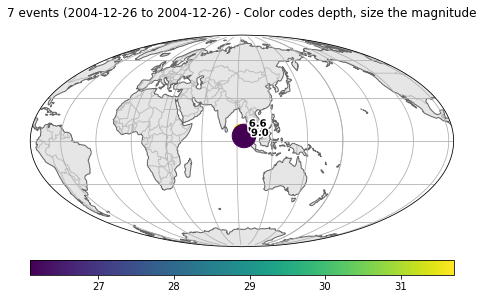

In [3]:
cat = client.get_events(starttime=t1, endtime=t2,
                        minmagnitude=6, catalog="ISC")
print(cat)
cat.plot();

## Read stations

Now that we know we have got the time window rigth, let's see which stations were available at that time that we can use later to try to relocate this event.

Inventory created at 2021-07-27T14:04:49.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2004-12-25...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			IU
		Stations (74):
			IU.ADK (Adak, Aleutian Islands, Alaska)
			IU.AFI (Afiamalu, Samoa)
			IU.ANMO (Albuquerque, New Mexico, USA)
			IU.ANTO (Ankara, Turkey)
			IU.BBSR (Bermuda Institute of Ocean Sciences, St George's Bermuda)
			IU.BILL (Bilibino, Russia)
			IU.CASY (Casey, Antarctica)
			IU.CCM (Cathedral Cave, Missouri, USA)
			IU.CHTO (Chiang Mai, Thailand)
			IU.COLA (College Outpost, Alaska, USA)
			IU.COR (Corvallis, Oregon, USA)
			IU.CTAO (Charters Towers, Australia)
			IU.DAV (Davao, Philippines)
			IU.DWPF (Disney Wilderness Preserve, Florida, USA)
			IU.FUNA (Funafuti, Tuvalu)
			IU.FURI (Mt. Furi, Ethiopia)
			IU.GNI (Garni, Armenia)
			IU.GRFO (Grafenberg, Germany)
			IU.GUMO (Guam, Mariana Islands)
			IU.HKT (

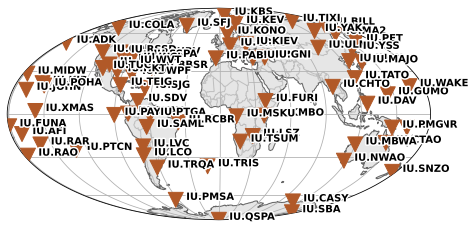

In [4]:
inventory = client.get_stations(network="IU", station="*",
                                starttime=t1,
                                endtime=t2)
print(inventory)  
inventory.plot();

## Read seismograms from database

The following example illustrates how to request and plot 60 minutes of the `LHZ` channel of station Albuquerque, New Mexico (`ANMO`) of the Global Seismograph Network (`IU`) for an seismic event around the Sumatra Earthquake.

In [5]:
# Define quiet time for comparison
tquiet = UTCDateTime("2004-10-26T00:58:53")

In [6]:
stquiet = client.get_waveforms("IU", "ANMO", "00", "LHZ", 
                               tquiet, tquiet + 60 * 60)
stsumatra = client.get_waveforms("IU", "ANMO", "00", "LHZ", 
                                 t1, t2)

In [7]:
stsumatra, stsumatra[0].stats

(1 Trace(s) in Stream:
IU.ANMO.00.LHZ | 2004-12-25T23:58:53.485600Z - 2004-12-26T04:58:52.485600Z | 1.0 Hz, 18000 samples,
                network: IU
               station: ANMO
              location: 00
               channel: LHZ
             starttime: 2004-12-25T23:58:53.485600Z
               endtime: 2004-12-26T04:58:52.485600Z
         sampling_rate: 1.0
                 delta: 1.0
                  npts: 18000
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 16, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 65536})
            processing: ['ObsPy 1.2.2: trim(endtime=UTCDateTime(2004, 12, 26, 4, 58, 53, 485600)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2004, 12, 25, 23, 58, 53, 485600))'])

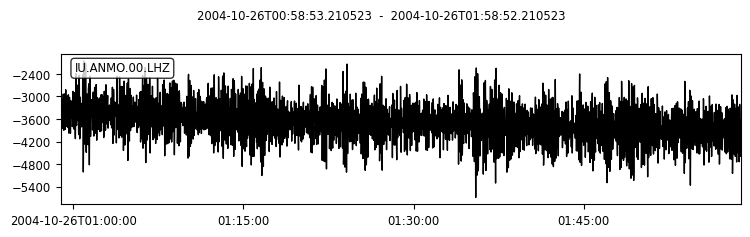

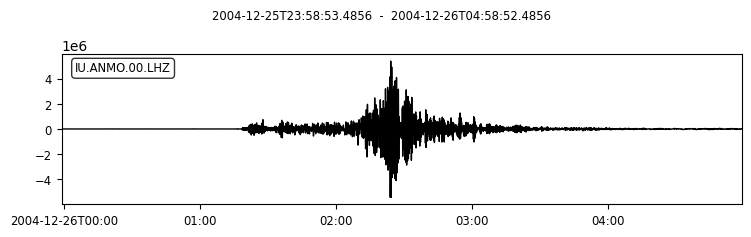

In [8]:
stquiet.plot()
stsumatra.plot();

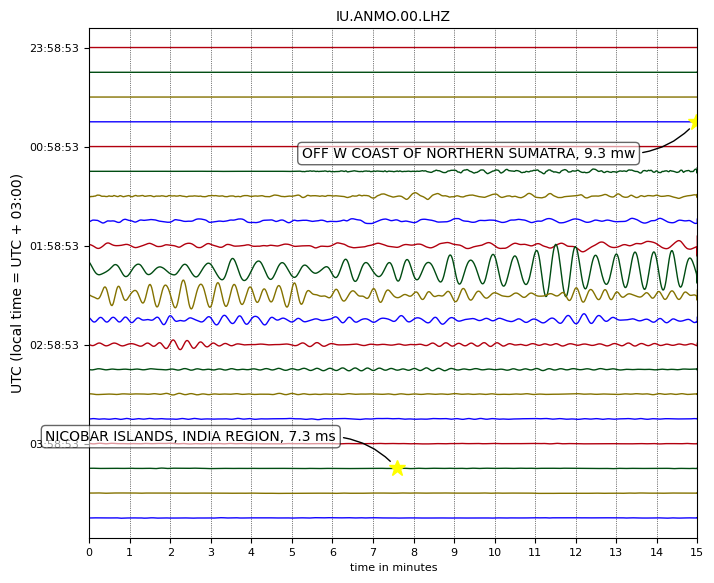

In [9]:
stsumatra.plot(type='dayplot', events={'min_magnitude': 6.5});

We can also get multiple seismograms at the same time, both specific a list of stations or recordings with `,` as well as using wildcards

In [10]:
stsumatra = client.get_waveforms("IU", "FURI,TIXI", "00", "LH*", t1, t2)
stsumatra

6 Trace(s) in Stream:
IU.FURI.00.LHE | 2004-12-25T23:58:53.510600Z - 2004-12-26T04:58:52.510600Z | 1.0 Hz, 18000 samples
IU.FURI.00.LHN | 2004-12-25T23:58:53.510600Z - 2004-12-26T04:58:52.510600Z | 1.0 Hz, 18000 samples
IU.FURI.00.LHZ | 2004-12-25T23:58:53.510600Z - 2004-12-26T04:58:52.510600Z | 1.0 Hz, 18000 samples
IU.TIXI.00.LHE | 2004-12-25T23:58:53.823500Z - 2004-12-26T04:58:52.823500Z | 1.0 Hz, 18000 samples
IU.TIXI.00.LHN | 2004-12-25T23:58:53.823500Z - 2004-12-26T04:58:52.823500Z | 1.0 Hz, 18000 samples
IU.TIXI.00.LHZ | 2004-12-25T23:58:53.823500Z - 2004-12-26T04:58:52.823500Z | 1.0 Hz, 18000 samples

Finally we can also filter our seismograms with a band-pass filter

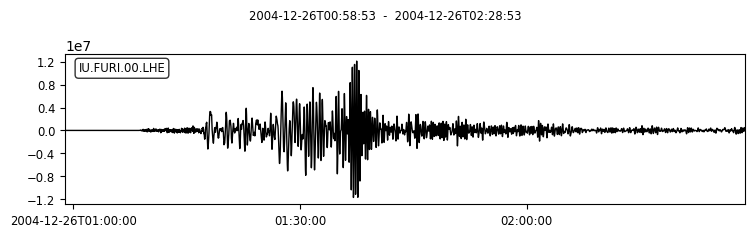

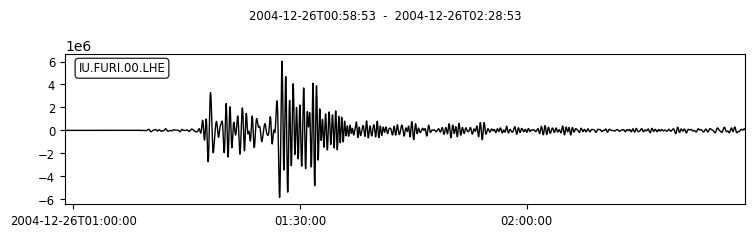

In [11]:
stsumatra_filt = stsumatra[:3].copy()
stsumatra_filt.filter('bandpass', freqmin=0.01, freqmax=0.04, zerophase=True)
   
stsumatra[0].plot(starttime=tsumatra, endtime=tsumatra+60*90);
stsumatra_filt[0].plot(starttime=tsumatra, endtime=tsumatra+60*90);

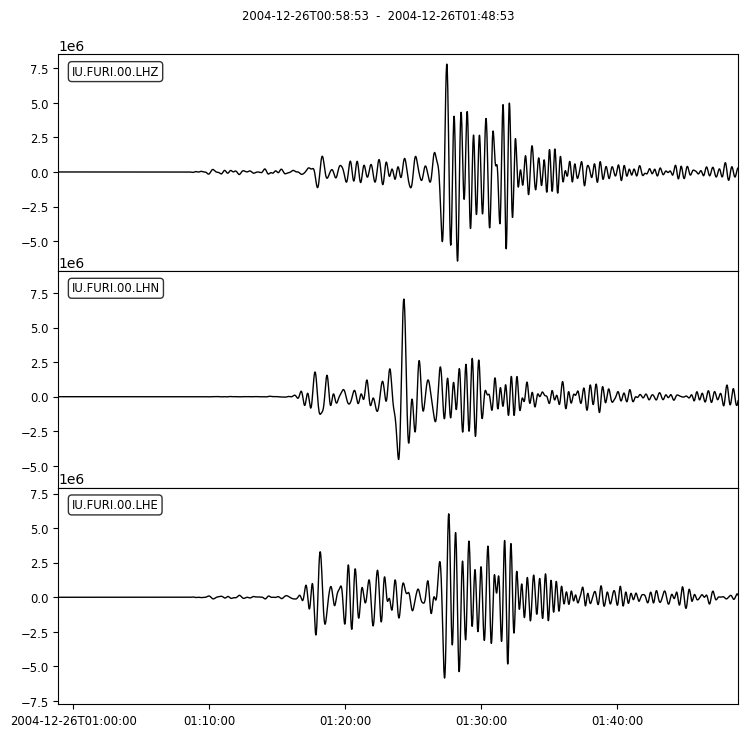

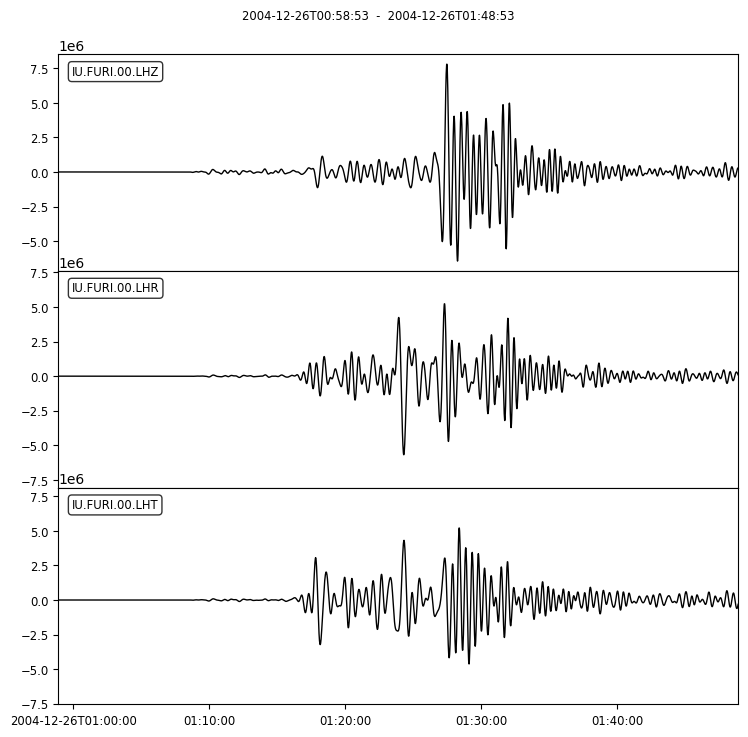

In [12]:
stsumatra_rot = stsumatra_filt[:3].copy()
stsumatra_rot = stsumatra_rot.rotate(method="NE->RT", back_azimuth=45)

fig = stsumatra_filt.plot(starttime=tsumatra, endtime=tsumatra+60*50);
fig = stsumatra_rot.plot(starttime=tsumatra, endtime=tsumatra+60*50);

## P and S time tables

Finally we see how *P and S time tables* can be created for different models of the Earth using Obspy. These are very useful as they help in defining the epicenter of an event given the picked P and S first arrival times for 3 or more stations.

More details: https://docs.obspy.org/packages/obspy.taup.html

In [13]:
# Define model
model = TauPyModel(model="iasp91")

# Choose angle and phases
degree = 90
npoints = 101
phase_list=["P", "S"]

# Get traveltimes
arrivals = model.get_travel_times(source_depth_in_km=100,
                                  distance_in_degree=degree, 
                                  phase_list=phase_list)
print(arrivals)

for arrival in arrivals:
    if arrival.name == 'P':
        print('Arrival time P:', arrival.time)
    elif arrival.name == 'S':
        print('Arrival time S:', arrival.time)

# Compute distance from degrees
print('Distance time P:', degrees2kilometers(degree, radius=6371))

2 arrivals
	P phase arrival at 768.167 seconds
	S phase arrival at 1412.792 seconds
Arrival time P: 768.167128585
Arrival time S: 1412.79225393
Distance time P: 10007.543398010286


Note that you can simply look over a range of angles and create P and S wave traveltime tables as function of angle and/or distance from epicenter.

## Display world maps

Finally I provide a useful routine that allows plotting a circle around a `(lat, long)` center of a certain radius. We will use Cartopy for plotting (which is the same library used in Obspy).

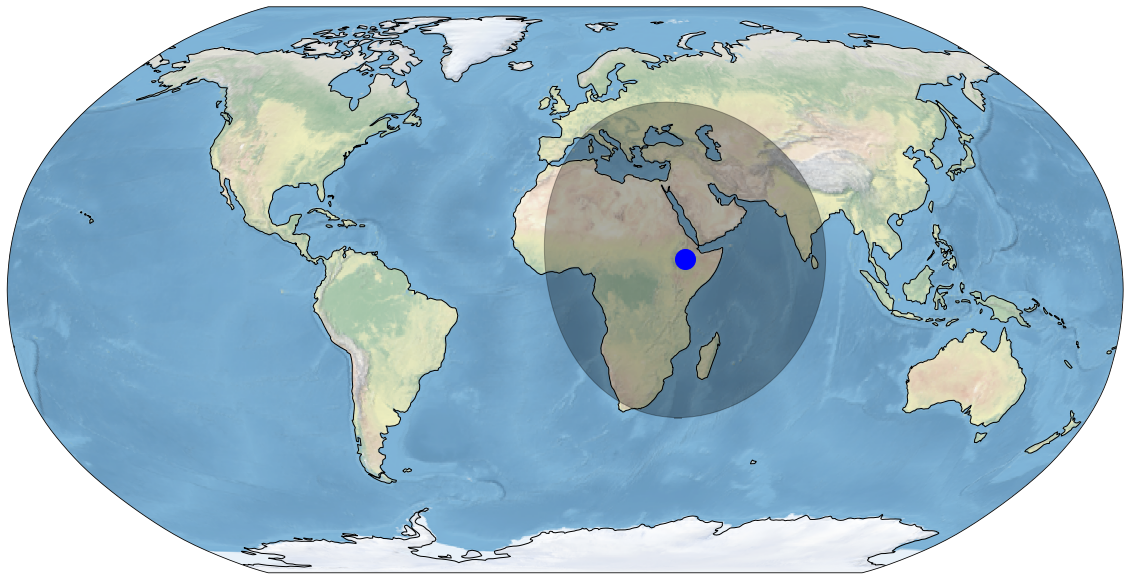

In [14]:
# from https://stackoverflow.com/questions/31492220/how-to-plot-a-tissot-with-cartopy-and-matplotlib
def circle(geod, lon, lat, radius, n_samples=360):
    """
    Return the coordinates of a geodetic circle of a given
    radius about a lon/lat point.

    Radius is in meters in the geodetic's coordinate system.

    """
    lons, lats, back_azim = geod.fwd(np.repeat(lon, n_samples),
                                     np.repeat(lat, n_samples),
                                     np.linspace(360, 0, n_samples),
                                     np.repeat(radius, n_samples),
                                     radians=False)
    return lons, lats


geod = Geod(ellps='WGS84')
    
plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.Robinson())
ax.stock_img()
ax.coastlines()

istation = 15
plt.plot(inventory[0][istation].longitude, inventory[0][istation].latitude,
         color='b', markersize=20, marker='o',
         transform=ccrs.Geodetic())

lons, lats = circle(geod, inventory[0][istation].longitude, inventory[0][istation].latitude, 5000 * 1e3, 100)
ax.add_geometries([sgeom.Polygon(zip(lons, lats)), ], ccrs.Geodetic(), color='k', alpha=0.3);